# Geospatial analysis of the determinants of cancer screening participation

![caption](Data/screeningprocess.png)

Figure 1. Overview of the breast cancer screening process the way in which it is commonly executed in Europe. In some countries (such as Germany) not all women who are invited participate in regular screening, but sometimes go opportunistically for a diagnostic mammogram. This is referred to as ‘gray screening’. (image by author)

![caption](Data/differentrates.png)


Figure 3. Illustration of different ‘rates’ in the screening process. The big gray blob represents all women in the age group which are screened, the orange circle all women that actually attend screening, the dark red circle all women that are recalled, the bright blue circle all cases that are biopsied and the bright red circle all cancers (image by author).

In [1]:
# Import misc
import pandas as pd
pd.set_option('display.max_columns', 500)
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import numpy as np
import glob
import random
import csv
import sys
import multiprocessing as mp
from difflib import SequenceMatcher
import pylab

# Imports spatial
import libpysal as lps
# import osmnx as ox
import mapclassify as mc
import esda
from shapely.geometry import Point, Polygon
import pysal as ps
from esda.join_counts import Join_Counts
from pysal.explore.pointpats import PointPattern
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
sys.path.append('/Users/david/Dropbox/PhD/Scripts/Spatial analyses')
import pyspace
# import pysal.lib.cg
from scipy.spatial import cKDTree
from libpysal.weights.distance import get_points_array
# from pysal.explore.pointpats import PointPattern, PoissonPointProcess, as_window, G, F, J, K, L, Genv, Fenv, Jenv, Kenv, Lenv

# Import stats
from pathlib import Path
import statsmodels.api as sm
from scipy import stats

# Import viz
from statsmodels.graphics.api import abline_plot
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
%matplotlib inline
import seaborn as sns

# Imports db
import psycopg2
from sqlalchemy import create_engine
engine = create_engine('postgresql://postgres@localhost:5432/david')


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/david/miniforge3/envs/py310/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/david/miniforge3/envs/py310/lib/python3.10/site-packages/quantecon/lss.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def simulate_linear_model(A, x0, v, ts_length):
/Users/david/minifo

# Load data

In [2]:
#Set working directory
mydir = Path(os.getcwd())

In [3]:
sql = """select *  from geounits.communes_ch_2056 where "KANTONSNUM"  = 25;"""
communes = gpd.GeoDataFrame.from_postgis(sql, con = engine, geom_col='geom' )
sql = """select *   from geounits.lake_2056 """
lake = gpd.GeoDataFrame.from_postgis(sql, con = engine, geom_col='geom' )

In [4]:
communes = gpd.overlay(communes,lake[lake.NOM == 'Léman'], how='difference')

In [5]:
data_folder = mydir / '../Data' #Set data folder
result_folder = mydir / '../Results' #Set data folder
file = data_folder /'Processed data'/ "20230627_GIRACS_all.feather" #Data source file containing the screening data
df = pd.read_feather(file)
#Transform to geodataframe
geometry = [Point(xy) for xy in zip(df['E'], df['N'])]
# Coordinate reference system : WGS84
crs = 'epsg:2056'
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [6]:
gdf_centre = gpd.read_file(data_folder/'Raw data'/'BC_ScreeningCenters.geojson',driver = 'GeoJSON')

In [7]:
geometry = [Point(xy) for xy in zip(gdf_centre['lon'], gdf_centre['lat'])]
# Coordinate reference system : WGS84
crs = 'epsg:4326'
gdf_centre = gpd.GeoDataFrame(gdf_centre, crs=crs, geometry=geometry)

In [8]:
def show_values(axs, orient="v",digits = 2, fontsize = 8, space=.05):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.02)
                value = '{:.{}f}'.format(p.get_height(), digits)
                ax.text(_x, _y, value,size = fontsize, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.{}f}'.format(p.get_width(), digits)
                ax.text(_x, _y, value,size = fontsize, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax, digits)
    else:
        _single(axs)

In [9]:
print('Number of invitations: ',gdf.shape[0])
print('Number of women: ',gdf.numerodossier.nunique())

Number of invitations:  579033
Number of women:  134814


# Data filtering

In [10]:
#Get number of people in the dataframe
print('Number of invitations: ',gdf.shape[0])
print('Number of people in the dataset: ',len(gdf.numerodossier.unique()))
patients = gdf[['numerodossier','medecin_code','autremedecin_code','mammoanterieure','atf_code','mammo','rappel']].groupby('numerodossier').sum(min_count = 1)
print('Number of people having done a breast cancer screening (mammography): ',len(patients[patients.mammo > 0]))

Number of invitations:  579033
Number of people in the dataset:  134814
Number of people having done a breast cancer screening (mammography):  55373


/var/folders/vs/k61m7qc90ds735nc0468d1x80000gn/T/ipykernel_40575/1451856826.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Text(0.5, 0, 'Colonnes')

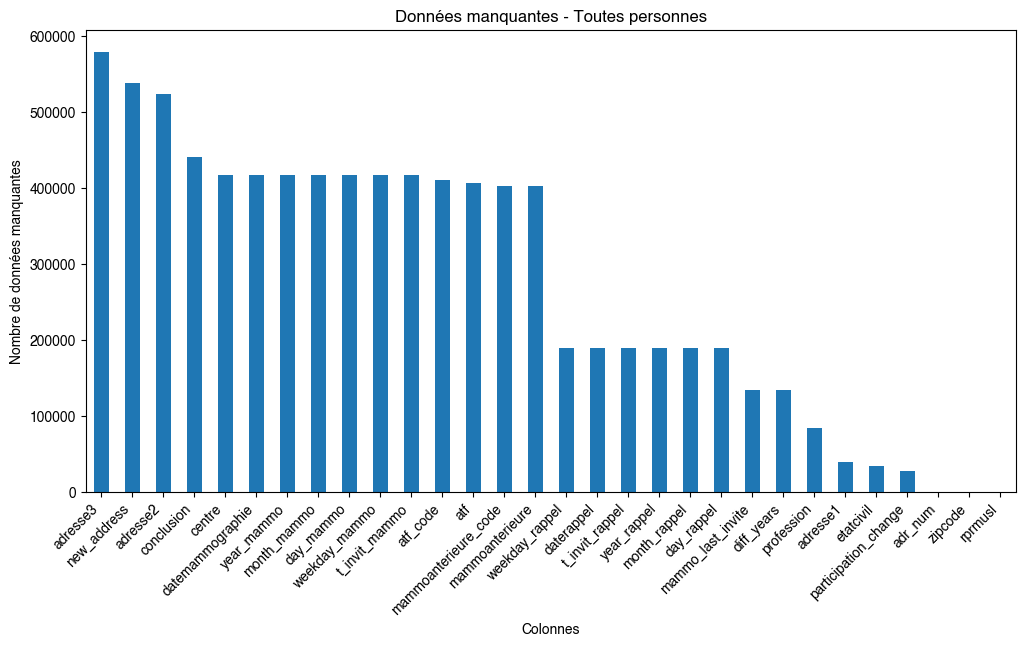

In [11]:
#Plot the 20 variables having the most NAs
isna_ = gdf.isnull().sum().sort_values(ascending=False)
plt.title('Données manquantes - Toutes personnes')
plt_1=isna_[:30].plot(kind='bar', figsize= (12,6))
plt_1.set_xticklabels(plt_1.get_xticklabels(),size = 10, rotation=45, horizontalalignment='right')
plt.ylabel('Nombre de données manquantes')
plt.xlabel('Colonnes')
# show_values(plt_1)

Text(0.5, 0, 'Colonnes')

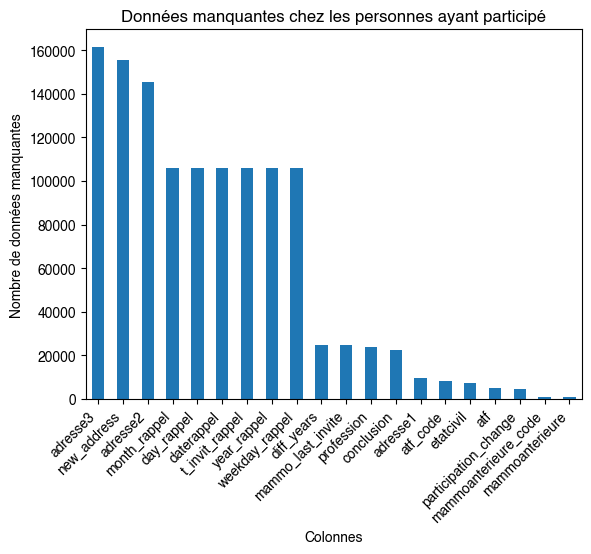

In [12]:
#Plot the 20 variables having the most NAs
isna_ = gdf[gdf.year_mammo.isnull()==False].isnull().sum().sort_values(ascending=False)

plt.title('Données manquantes chez les personnes ayant participé')
plt_1=isna_[:20].plot(kind='bar')
plt_1.set_xticklabels(plt_1.get_xticklabels(),size = 10, rotation=45, horizontalalignment='right')

plt.ylabel('Nombre de données manquantes')
plt.xlabel('Colonnes')

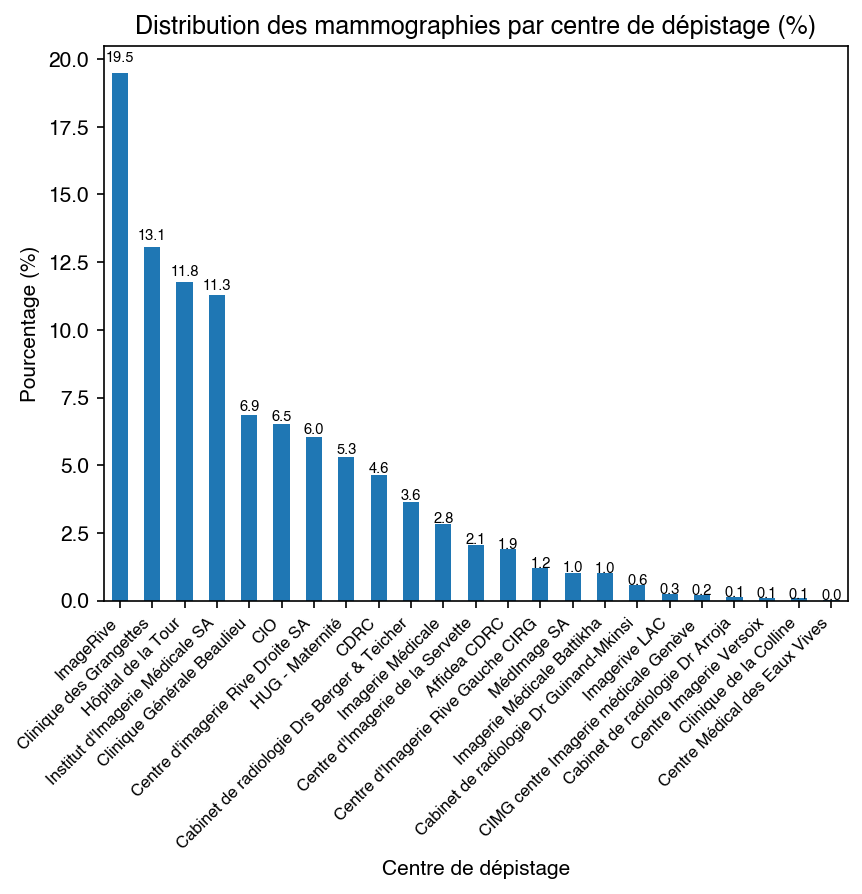

In [13]:
plt_1 = plt.subplots(dpi = 150)
plt_1 = gdf.centre.value_counts(normalize=True).mul(100).plot.bar()
plt_1.set_xticklabels(plt_1.get_xticklabels(),size = 8, rotation=45, horizontalalignment='right')

plt.title('Distribution des mammographies par centre de dépistage (%)')
plt.ylabel('Pourcentage (%)')
plt.xlabel('Centre de dépistage')
show_values(plt_1, digits = 1, fontsize = 7)

We see that the ImageRive is far ahead of any other center, gathering more than 20% of all screenings. We could test:

- Is this correlated to the total population living at less than 1,2,5k ?
    - Probably not that much, I highly doubt that Imagerive LAC has very little population around or that Clinique de la Colline has zero. 
    - Questions for Beatrice : Why would that be? Was that a known fact? Close to where people work? Incentives to go there (flyers, reputation of quality, recommendation from physician,convenience of getting an appointment,...)? 


In [14]:
patients.loc[patients.atf_code > 0, 'atf_code'] =1

In [15]:
df_final = gdf.copy()

## Distribution by age categories

In [16]:
#Get age categories that are too young or too old...(according to HUG guidelines)
# QUESTION : Why are these present at all?
age_cats = df.groupby('groupeage').size()
age_cats =  pd.DataFrame(age_cats).reset_index()
age_cats.columns = ["Groupe d'âge","Nombre d'invitations (N)"]

In [17]:
import six

In [18]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size, dpi = 120)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

<AxesSubplot:>

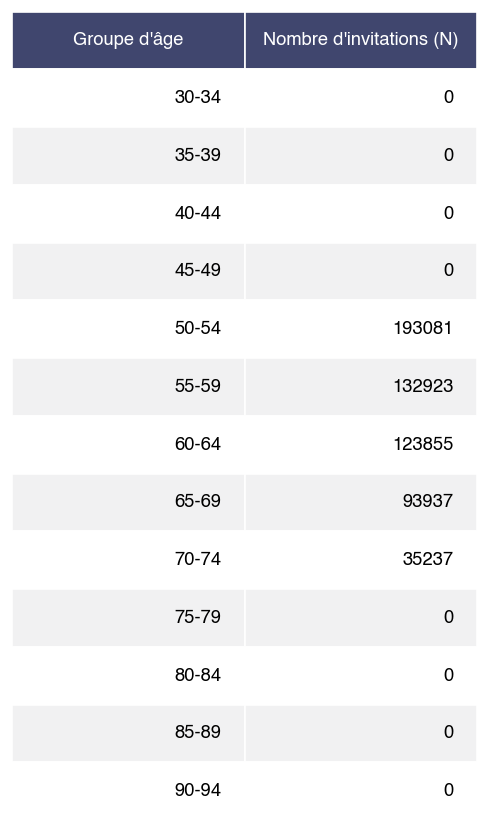

In [19]:
render_mpl_table(age_cats, header_columns=0, col_width=2.5, font_size = 11)

In [20]:
#Get number of people in the dataframe
print('Number of invitations: ',df_final.shape[0])
print('Number of people in the dataset: ',len(df_final.numerodossier.unique()))
patients = df_final[['numerodossier','medecin_code','autremedecin_code','mammoanterieure','atf_code','mammo','rappel']].groupby('numerodossier').sum(min_count = 1)
print('Number of people having done a breast cancer screening (mammography): ',len(patients[patients.mammo > 0]))

Number of invitations:  579033
Number of people in the dataset:  134814
Number of people having done a breast cancer screening (mammography):  55373


/var/folders/vs/k61m7qc90ds735nc0468d1x80000gn/T/ipykernel_40575/4263921931.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



## Geocoding

In [21]:
geocoding_res = pd.DataFrame(df.comment.value_counts()).reset_index()

In [22]:
# # sns.set_theme(style="white")
# # sns.set_context("paper")

# # fig, ax = plt.subplots(figsize = (8,8))
# fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharey=False)
# fig.suptitle('Résultats géocodage')
# geocoding_res = pd.DataFrame(df.comment.value_counts()).reset_index()
# geocoding_res['count'] = geocoding_res['count'].astype(int)
# chart = sns.barplot(x="comment", y="count", data=geocoding_res, ax = axes[0])
# chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
# chart.set_xlabel('Classes de géocodage',size = 14)
# chart.set_ylabel('Nombre',size = 14)

# chart = sns.barplot(x="comment", y="count", data=geocoding_res, ax = axes[1])
# chart.set_yscale("log")
# chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
# chart.set_xlabel('Classes de géocodage',size = 14)
# chart.set_ylabel('Nombre',size = 14)
# show_values(chart)

# geocoding_res = pd.DataFrame(df.comment.value_counts(normalize = True).mul(100)).reset_index()
# chart = sns.barplot(x="comment", y="proportion", data=geocoding_res, ax = axes[2])
# chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
# chart.set_xlabel('Classes de géocodage',size = 14)
# chart.set_ylabel('Nombre',size = 14)
# show_values(chart)


## Number of invitations by year

Women invited in 2019 are excluded since they might not have had the time to participate at the time of data extraction

<AxesSubplot:>

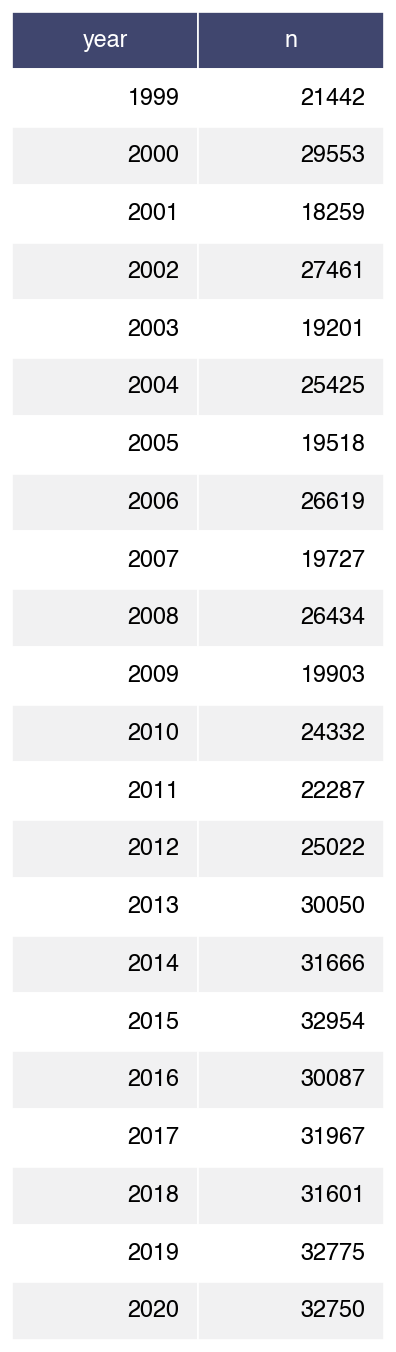

In [23]:
year_cats = df_final.groupby('year_invit').size()
year_cats =  pd.DataFrame(year_cats).reset_index()
year_cats.columns = ['year','n']
render_mpl_table(year_cats, header_columns=0, col_width=2.0)

In [24]:
#Get number of people in the dataframe
print('Number of invitations: ',df_final.shape[0])
print('Number of people in the dataset: ',len(df_final.numerodossier.unique()))
patients = df_final[['numerodossier','medecin_code','autremedecin_code','mammoanterieure','atf_code','mammo','rappel']].groupby('numerodossier').sum(min_count = 1)
print('Number of people having done a breast cancer screening (mammography): ',len(patients[patients.mammo > 0]))

Number of invitations:  579033
Number of people in the dataset:  134814
Number of people having done a breast cancer screening (mammography):  55373


/var/folders/vs/k61m7qc90ds735nc0468d1x80000gn/T/ipykernel_40575/4263921931.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



## Disparity between "numeroinvitation" and actual number of invitations recorded in the database

In [25]:
# #Return a sequence that corresponds to the actual numeroinvitation ...without the weird things we find in the original column
# df_final['dt_invit'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df_final.year_invit, df_final.month_invit, df_final.day_invit)])
# df_final = df_final.sort_values(['numerodossier','dt_invit'])
# df_final['numeroinvitation_seq'] = df_final.groupby('numerodossier').cumcount()+1

In [26]:
df_final.groupby('numeroinvitation_seq').size()

numeroinvitation_seq
1     134404
2     105586
3      85012
4      67568
5      52609
6      41138
7      32055
8      25352
9      18087
10     11487
11      5317
12       366
13        43
14         7
15         2
dtype: int64

In [27]:
print('Number of invitations: ',df_final.shape[0])

Number of invitations:  579033


## Number of invitations by woman



In [28]:
# n_invit = df_final.groupby('numerodossier').numeroinvitation_seq.nunique()
# df_final = df_final.join(n_invit, on='numerodossier', rsuffix='_n')

In [29]:
n_invit = df_final.groupby('numerodossier').numeroinvitation_seq.nunique()
# df_final = df_final.join(n_invit, on='numerodossier', rsuffix='_n')

### # by numeroinvitation (= number of women having received at least N invitations)

<AxesSubplot:>

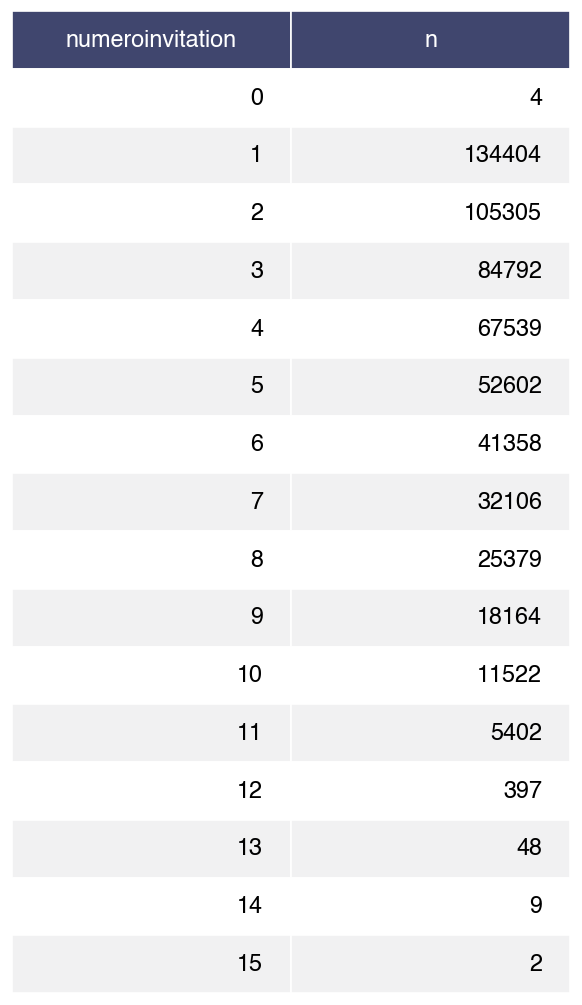

In [30]:
women_by_n_invite = df_final[['numerodossier','numeroinvitation']].drop_duplicates().groupby('numeroinvitation').count().reset_index()
women_by_n_invite.columns = ['numeroinvitation','n']
render_mpl_table(women_by_n_invite, header_columns=0, col_width=3.0)

### # by actual number of invitations recorded in the database

<AxesSubplot:>

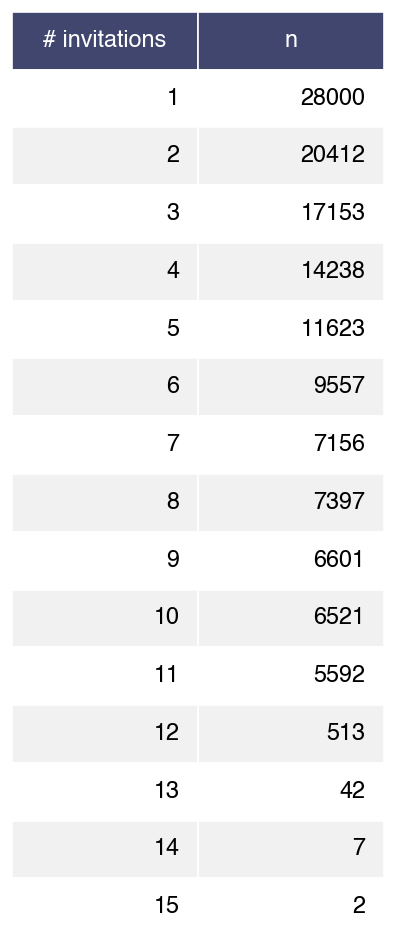

In [31]:
women_by_n_invite = df_final[['numerodossier','numeroinvitation_seq_n']].drop_duplicates().groupby('numeroinvitation_seq_n').count().reset_index()
women_by_n_invite.columns = ['# invitations','n']
render_mpl_table(women_by_n_invite, header_columns=0, col_width=2.0)

##  Women invited at least 3 times

In [32]:
n_invit3 = n_invit[n_invit>2]
df_final_3invit = df_final[(df_final.numerodossier.isin(n_invit3.index))].sort_values(['numerodossier','numeroinvitation'])

## Time intervals between any two invitation (to the same woman)

In [33]:
dossiers_bug = df_final[df_final.diff_years < 0].numerodossier.values
dossiers_timing_long = df_final[df_final.diff_years > 3].numerodossier.values
dossiers_timing_court = df_final[(df_final.diff_years < 1)&(df_final.diff_years >= 0)].numerodossier.values
#
# df_final = df_final[(df_final.numerodossier.isin(dossiers_bug) == False)]
# df_final = df_final[(df_final.numerodossier.isin(dossiers_timing_long) == False)]
# df_final = df_final[(df_final.numerodossier.isin(dossiers_timing_court) == False)]

In [34]:
print('Number of dossiers were the interval between any two invitations is negative : {}'.format(dossiers_bug.shape[0]))

print('Number of dossiers were at least one invitation has been sent in an interval of more than 3 years after the precedent : {}'.format(dossiers_timing_long.shape[0]))

print('Number of dossiers were at least one invitation has been sent in interval of more less than 1 years after the precedent : {}'.format(dossiers_timing_court.shape[0]))

Number of dossiers were the interval between any two invitations is negative : 0
Number of dossiers were at least one invitation has been sent in an interval of more than 3 years after the precedent : 17177
Number of dossiers were at least one invitation has been sent in interval of more less than 1 years after the precedent : 5627


I am unsure at this time if they should be discarded...It might not be a big problem

## Participation changes between any two invitation (to the same woman)

<AxesSubplot:>

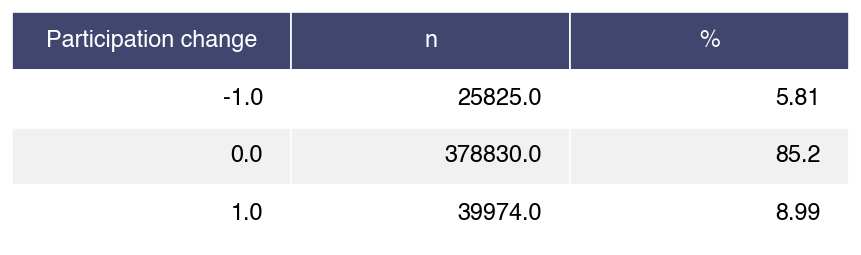

In [35]:
participation_chg = pd.DataFrame(df_final[['numerodossier','mammo_last_invite']].groupby(['mammo_last_invite']).numerodossier.count()).reset_index()
participation_chg.columns = ['Participation change','n']
participation_chg['%'] = participation_chg['n'].mul(100)/participation_chg['n'].sum(axis = 0)
participation_chg['%'] = participation_chg['%'].round(2)
render_mpl_table(participation_chg, header_columns=0, col_width=3.0)

In [36]:
# participation_change = df_final[['numerodossier','mammo_last_invite']].dropna().groupby(['numerodossier']).mammo_last_invite.nunique().reset_index()
# participation_change.columns = ['numerodossier','participation_change']
# participation_change['participation_change'] = participation_change['participation_change']-1

In [ ]:
ss_income = pd.read_excel('../../GeoSalt/Data/OCTSTAT_historique_revenus_2005_2016.xlsx',sheet_name = "Sheet1")

In [ ]:
query = """select * from geounits.geo_girec;"""
geo_girec = gpd.GeoDataFrame.from_postgis(query,con = engine,geom_col = 'geom')

In [ ]:
geo_girec['NUMERO'] = geo_girec['NUMERO'].astype(int)

ss_income = pd.merge(ss_income,geo_girec[['NUMERO','geom']],left_on = 'code_ss',right_on = 'NUMERO',how = 'left').drop('NUMERO',axis = 1)

ss_income = gpd.GeoDataFrame(ss_income,geometry = ss_income['geom'])
ss_income.crs = 'epsg:2056'

df_final = gpd.sjoin(df_final,ss_income, how = 'left',predicate = 'intersects').drop('index_right',axis = 1)

In [ ]:
df_final.loc[df_final.year_invit < 2006,'income_ss'] = df_final[2005]
df_final.loc[df_final.year_invit == 2006,'income_ss'] = df_final[2006]
df_final.loc[df_final.year_invit == 2007,'income_ss'] = df_final[2007]
df_final.loc[df_final.year_invit == 2008,'income_ss'] = df_final[2008]
df_final.loc[df_final.year_invit == 2009,'income_ss'] = df_final[2009]
df_final.loc[df_final.year_invit == 2010,'income_ss'] = df_final[2010]
df_final.loc[df_final.year_invit == 2011,'income_ss'] = df_final[2011]
df_final.loc[df_final.year_invit == 2012,'income_ss'] = df_final[2012]
df_final.loc[df_final.year_invit == 2013,'income_ss'] = df_final[2013]
df_final.loc[df_final.year_invit == 2014,'income_ss'] = df_final[2014]
df_final.loc[df_final.year_invit == 2015,'income_ss'] = df_final[2015]
df_final.loc[df_final.year_invit >= 2016,'income_ss'] = df_final[2016]

In [ ]:
df_final.shape

In [ ]:
# df_final = df_final[~df_final.income_ss.isnull()]
participants_after = df_final.shape[0]
print(f'After removing respondents who were missing income there were left {participants_after} participants.')
print('Number of people in the dataset: ',len(df_final.numerodossier.unique()))

# Descriptive analyses

In [40]:
age_group = df_final.groupby('groupeage').sum()/df_final.groupby('groupeage').count()
age_group['Age group'] = age_group.index

/var/folders/vs/k61m7qc90ds735nc0468d1x80000gn/T/ipykernel_40575/1251592822.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [41]:
c = df_final.groupby(['groupeage','atf_code'])['atf_code'].count()
test = (c / c.groupby(level=[0]).transform("sum")).unstack('atf_code').fillna(0)
yerr = ((test[1]*(1-test[1]))/(c.unstack('atf_code')[0]+c.unstack('atf_code')[1]))**(0.5)
test *=100
yerr *= 100

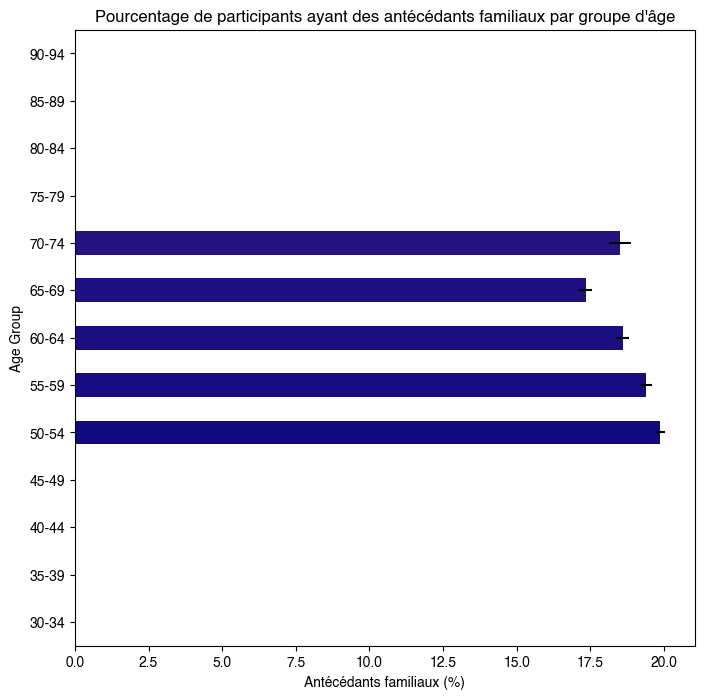

In [42]:
f,ax = plt.subplots(figsize = (8,8))
my_colors = ['r', 'b']*5 # <-- this concatenates the list to itself 5 times.
my_colors = [(0.5,0.8,0.5), (1, 1, 1)]*5 # <-- make two custom RGBs and repeat/alternate them over all the bar elements.
my_colors = [(x/59.0, x/114.0, 0.5) for x in range(len(test[1]))]
test[1].plot(kind = 'barh',xerr = yerr,color = my_colors,ax = ax)
ax.set_title("Pourcentage de participants ayant des antécédants familiaux par groupe d'âge")
ax.set_ylabel('Age Group')
ax.set_xlabel('Antécédants familiaux (%)')
plt.savefig(result_folder/'atf_by_agegroup.png',bbox_inches='tight', transparent=True,dpi = 400)

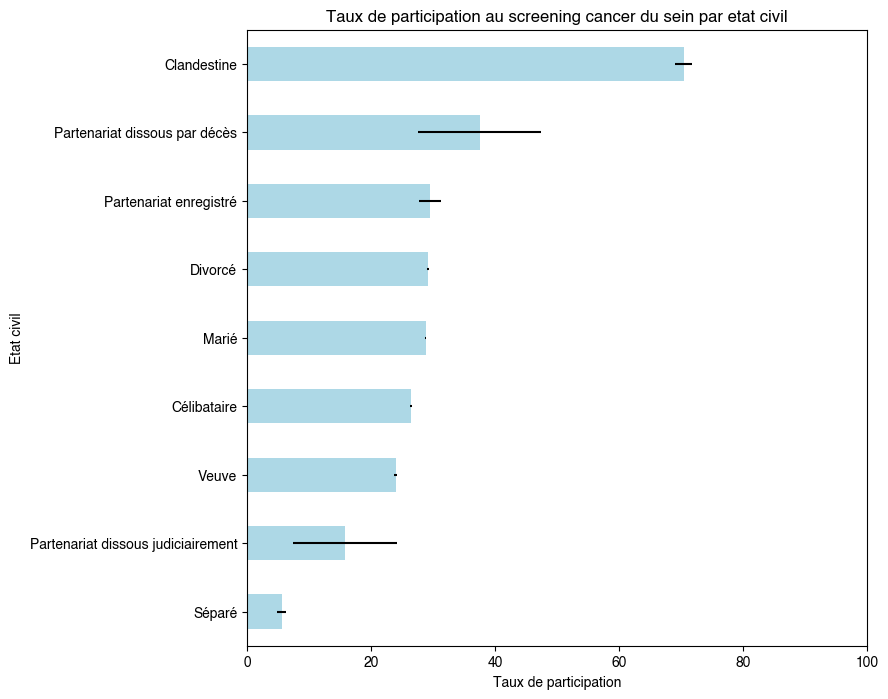

In [43]:
c = df_final.groupby(['etatcivil','mammo'])['mammo'].count()
test = (c / c.groupby(level=[0]).transform("sum")).unstack('mammo').fillna(0)
yerr = ((test[1]*(1-test[1]))/(c.unstack('mammo')[0]+c.unstack('mammo')[1]))**(0.5)
test *=100
yerr *= 100
f,ax = plt.subplots(figsize = (8,8))
test[1].sort_values().plot(kind = 'barh',xerr = yerr,xlim = (0,100),color = ['lightblue'],ax = ax)
ax.set_title('Taux de participation au screening cancer du sein par etat civil')
ax.set_ylabel('Etat civil')
ax.set_xlabel('Taux de participation')
plt.savefig(result_folder/'tx_participation_etatcivil.png',bbox_inches='tight', transparent=True,dpi = 400)

In [44]:
patients_mammo = patients.groupby('mammo').count().medecin_code

In [45]:
patients_mammo['mammo_n'] = patients_mammo.index

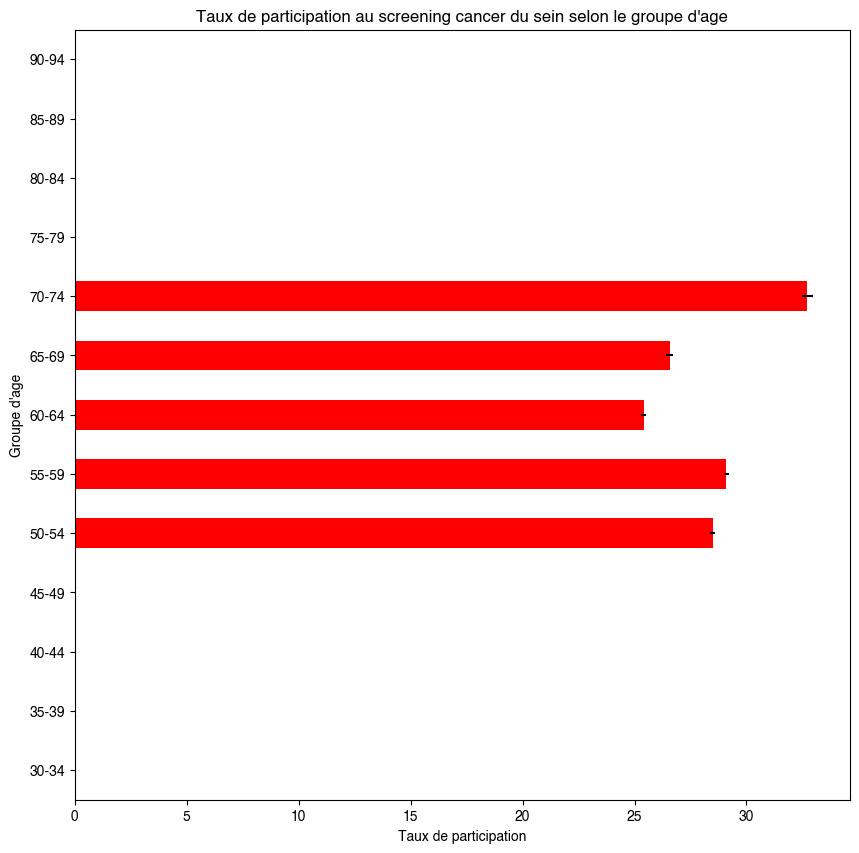

In [46]:
c = df_final.groupby(['groupeage','mammo'])['mammo'].count()
test = (c / c.groupby(level=[0]).transform("sum")).unstack('mammo').fillna(0)
yerr = ((test[1]*(1-test[1]))/(c.unstack('mammo')[0]+c.unstack('mammo')[1]))**(0.5)
test *=100
yerr *= 100

f,ax = plt.subplots(figsize = (10,10))
test[1].plot(kind = 'barh',xerr = yerr,color = ['red'],ax = ax)
ax.set_title('Taux de participation au screening cancer du sein selon le groupe d\'age')
ax.set_ylabel('Groupe d\'age')
ax.set_xlabel('Taux de participation')
plt.savefig(result_folder/'tx_participation_age.png',bbox_inches='tight', transparent=True,dpi = 400)

In [47]:
df_final[df_final.city.str.contains("SAINT")].city.values

array(['SAINT GENIS POUILLY '], dtype=object)

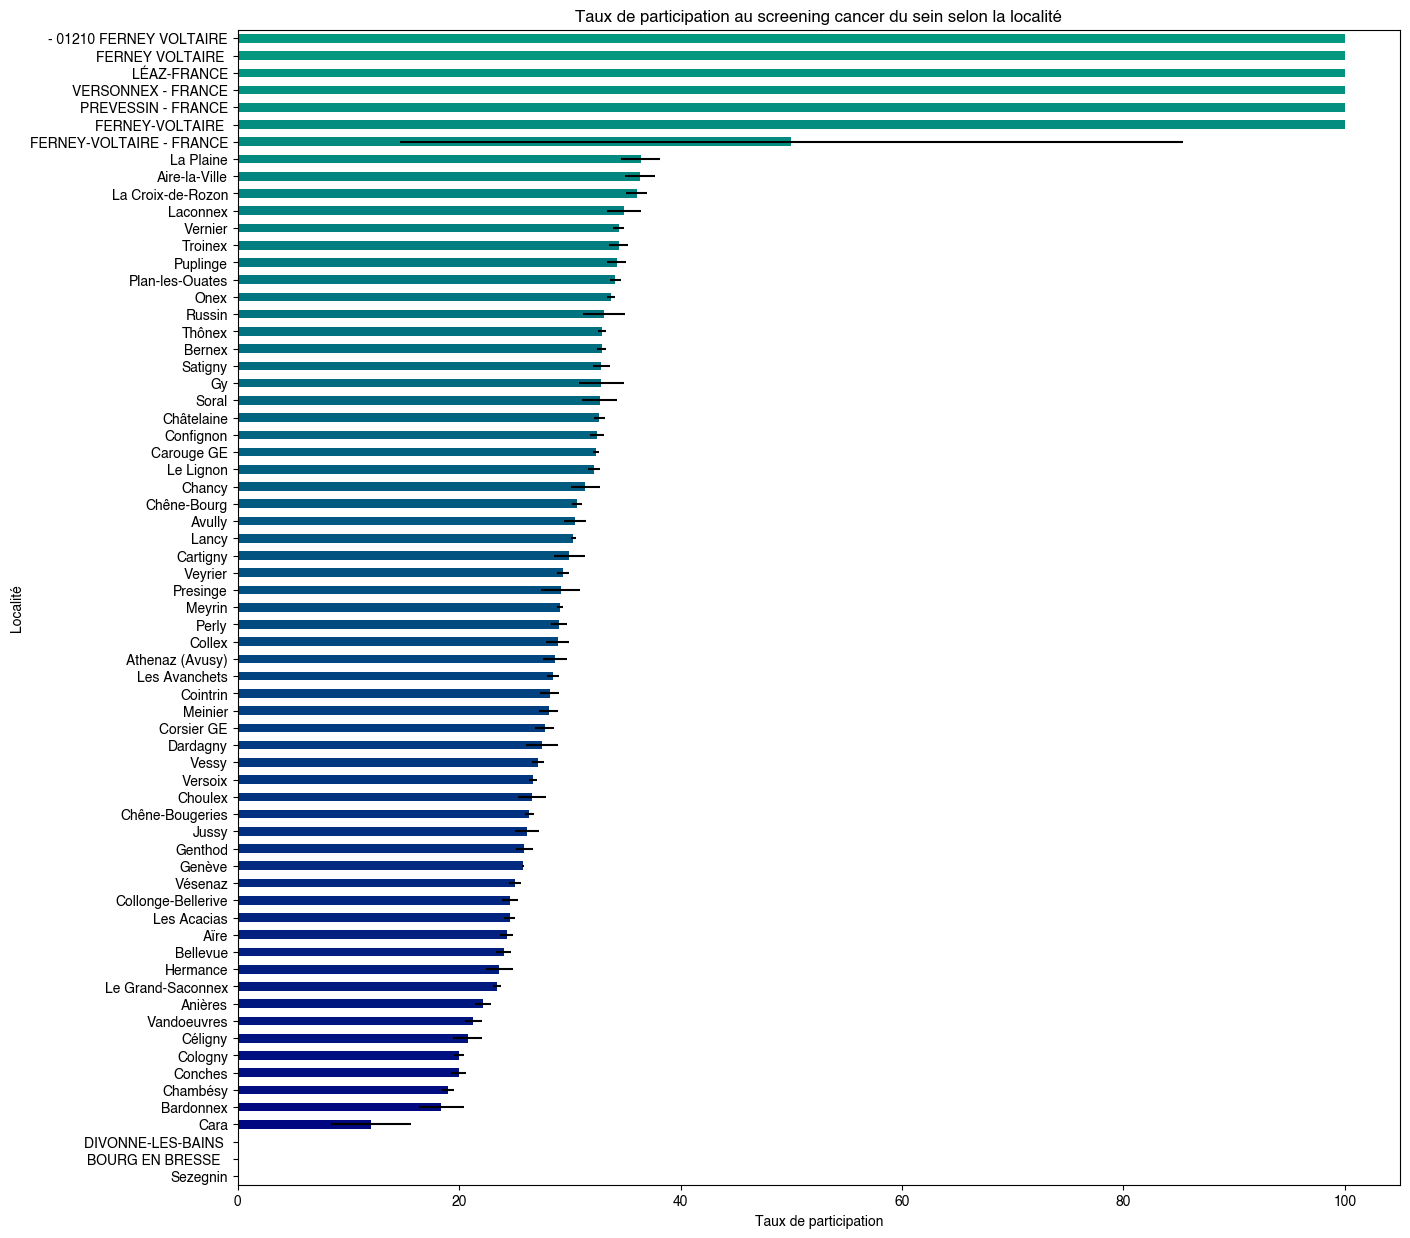

In [48]:
c = df_final[df_final.city.isin(['SAINT GENIS POUILLY ','La Rippe','Landecy']) == False].groupby(['city','mammo'], observed = True)['mammo'].count()
test = (c / c.groupby(level=[0]).transform("sum")).unstack('mammo').fillna(0)
yerr = ((test[1]*(1-test[1]))/(c.unstack('mammo')[0]+c.unstack('mammo')[1]))**(0.5)
test *=100
yerr *= 100

f,ax = plt.subplots(figsize = (15,15))
my_colors = ['r', 'b']*5 # <-- this concatenates the list to itself 5 times.
my_colors = [(0.5,0.8,0.5), (1, 1, 1)] # <-- make two custom RGBs and repeat/alternate them over all the bar elements.
my_colors = [(x/5900.0, x/110.0, 0.5) for x in range(len(test[1]))]
test[1].sort_values().plot(kind = 'barh',xerr = yerr,color = my_colors,ax = ax)
ax.set_title('Taux de participation au screening cancer du sein selon la localité')
ax.set_ylabel('Localité')
ax.set_xlabel('Taux de participation')
plt.savefig(result_folder/'tx_participation_locality.png',bbox_inches='tight', transparent=True,dpi = 400)

Get net income and gini index data from the federal office

http://www.estv2.admin.ch/f/dokumentation/zahlen_fakten/karten/dbst/2015/grafiken_2015.php

- Revenus nets

Le revenu net correspond à une valeur statistique déterminée par le revenu imposable auquel sont rajoutées les déductions fiscales pour enfants ou personnes nécessiteuses à charge, pour primes d'assurances et intérêts de capitaux d'épargne et pour double activité des conjoints.
 

- Revenu équivalent net

Pour pouvoir comparer le bien-être matériel des ménages de tailles différentes, le revenu net de chaque ménage est divisé par un facteur d'équivalence. Ce rapport entre le revenu net et le facteur d'équivalence constitue le revenu équivalent net. Un facteur d'équivalence de 1 est considéré pour les personnes seules et de 1.5 pour les couples de personnes mariées; à ces nombres est encore ajouté un montant de 0.3 par enfant ou par personne nécessiteuse à charge du contribuable. Par exemple, le revenu équivalent net d'un ménage de personnes mariées avec deux enfants à charge est égal au revenu net du ménage divisé par 2.1 (1.5+0.3+0.3). 

In [49]:
df_income_gini = pd.read_excel('/Users/david/Dropbox/PhD/Data/Databases/OFS/Revenus/revenus_nets.xls',sheet_name = 'prepared_data')
df_income_gini = df_income_gini[df_income_gini.canton == 'Genève']

In [50]:
c = df_final[df_final.city.isin(['SAINT GENIS POUILLY ','La Rippe','Landecy']) == False].groupby(['city','mammo'])['mammo'].count()
test = (c / c.groupby(level=[0]).transform("sum")).unstack('mammo').fillna(0)
test.columns = ['no','Participation rate']

In [51]:
df_income_gini = df_income_gini.set_index('commune').join(test)
df_income_gini['commune'] = df_income_gini.index

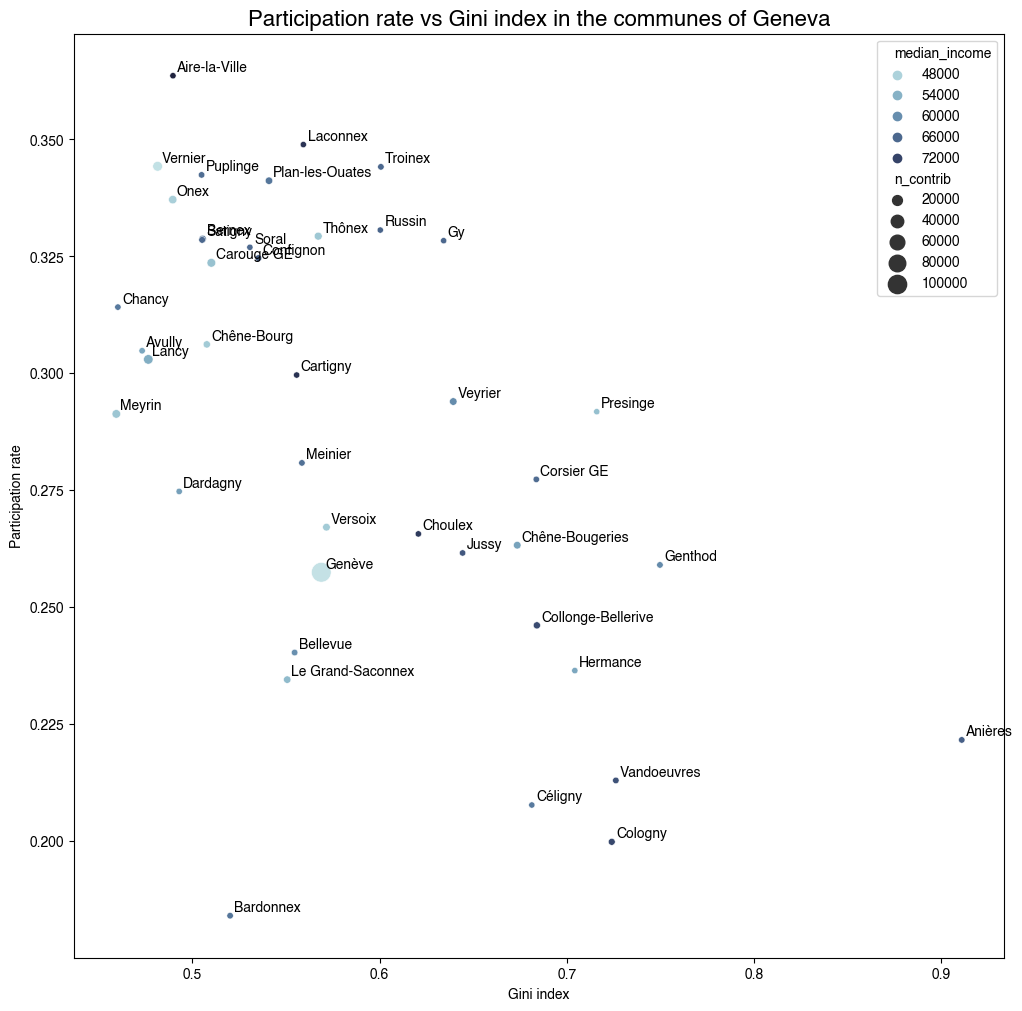

In [52]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
f,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(x="gini", y="Participation rate",markers = True,
                     hue="median_income", size="n_contrib",
                     palette=cmap, sizes=(20, 200),
                     data=df_income_gini,ax = ax)
for x,y,label in zip(df_income_gini.gini,df_income_gini['Participation rate'],df_income_gini.commune):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
ax.set_xlabel('Gini index')
ax.set_title('Participation rate vs Gini index in the communes of Geneva', fontsize = 16)
f.savefig(result_folder/'gini_participation_communes.png',bbox_inches='tight', transparent=True,dpi = 400)

In [53]:
df_desc_screen = pd.DataFrame()
df_desc_screen['Invited 1, n'] = df_final[df_final.numeroinvitation == 1].groupby('year_invit').numerodossier.count()
df_desc_screen['Round 1'] = df_final[(df_final.numeroinvitation == 1)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count().astype(str)+' ('+(df_final[(df_final.numeroinvitation == 1)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count()*100/df_desc_screen['Invited 1, n']).round(1).astype(str)+ '%)'
##
df_desc_screen['Invited 2, n'] = df_final[df_final.numeroinvitation == 2].groupby('year_invit').numerodossier.count()
df_desc_screen['Round 2'] = df_final[(df_final.numeroinvitation == 2)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count().astype(str)+' ('+(df_final[(df_final.numeroinvitation == 2)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count()*100/df_desc_screen['Invited 2, n']).round(1).astype(str)+ '%)'
##
df_desc_screen['Invited 3, n'] = df_final[df_final.numeroinvitation == 3].groupby('year_invit').numerodossier.count()
df_desc_screen['Round 3'] = df_final[(df_final.numeroinvitation == 3)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count().astype(str)+' ('+(df_final[(df_final.numeroinvitation == 3)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count()*100/df_desc_screen['Invited 3, n']).round(1).astype(str)+ '%)'

<AxesSubplot:>

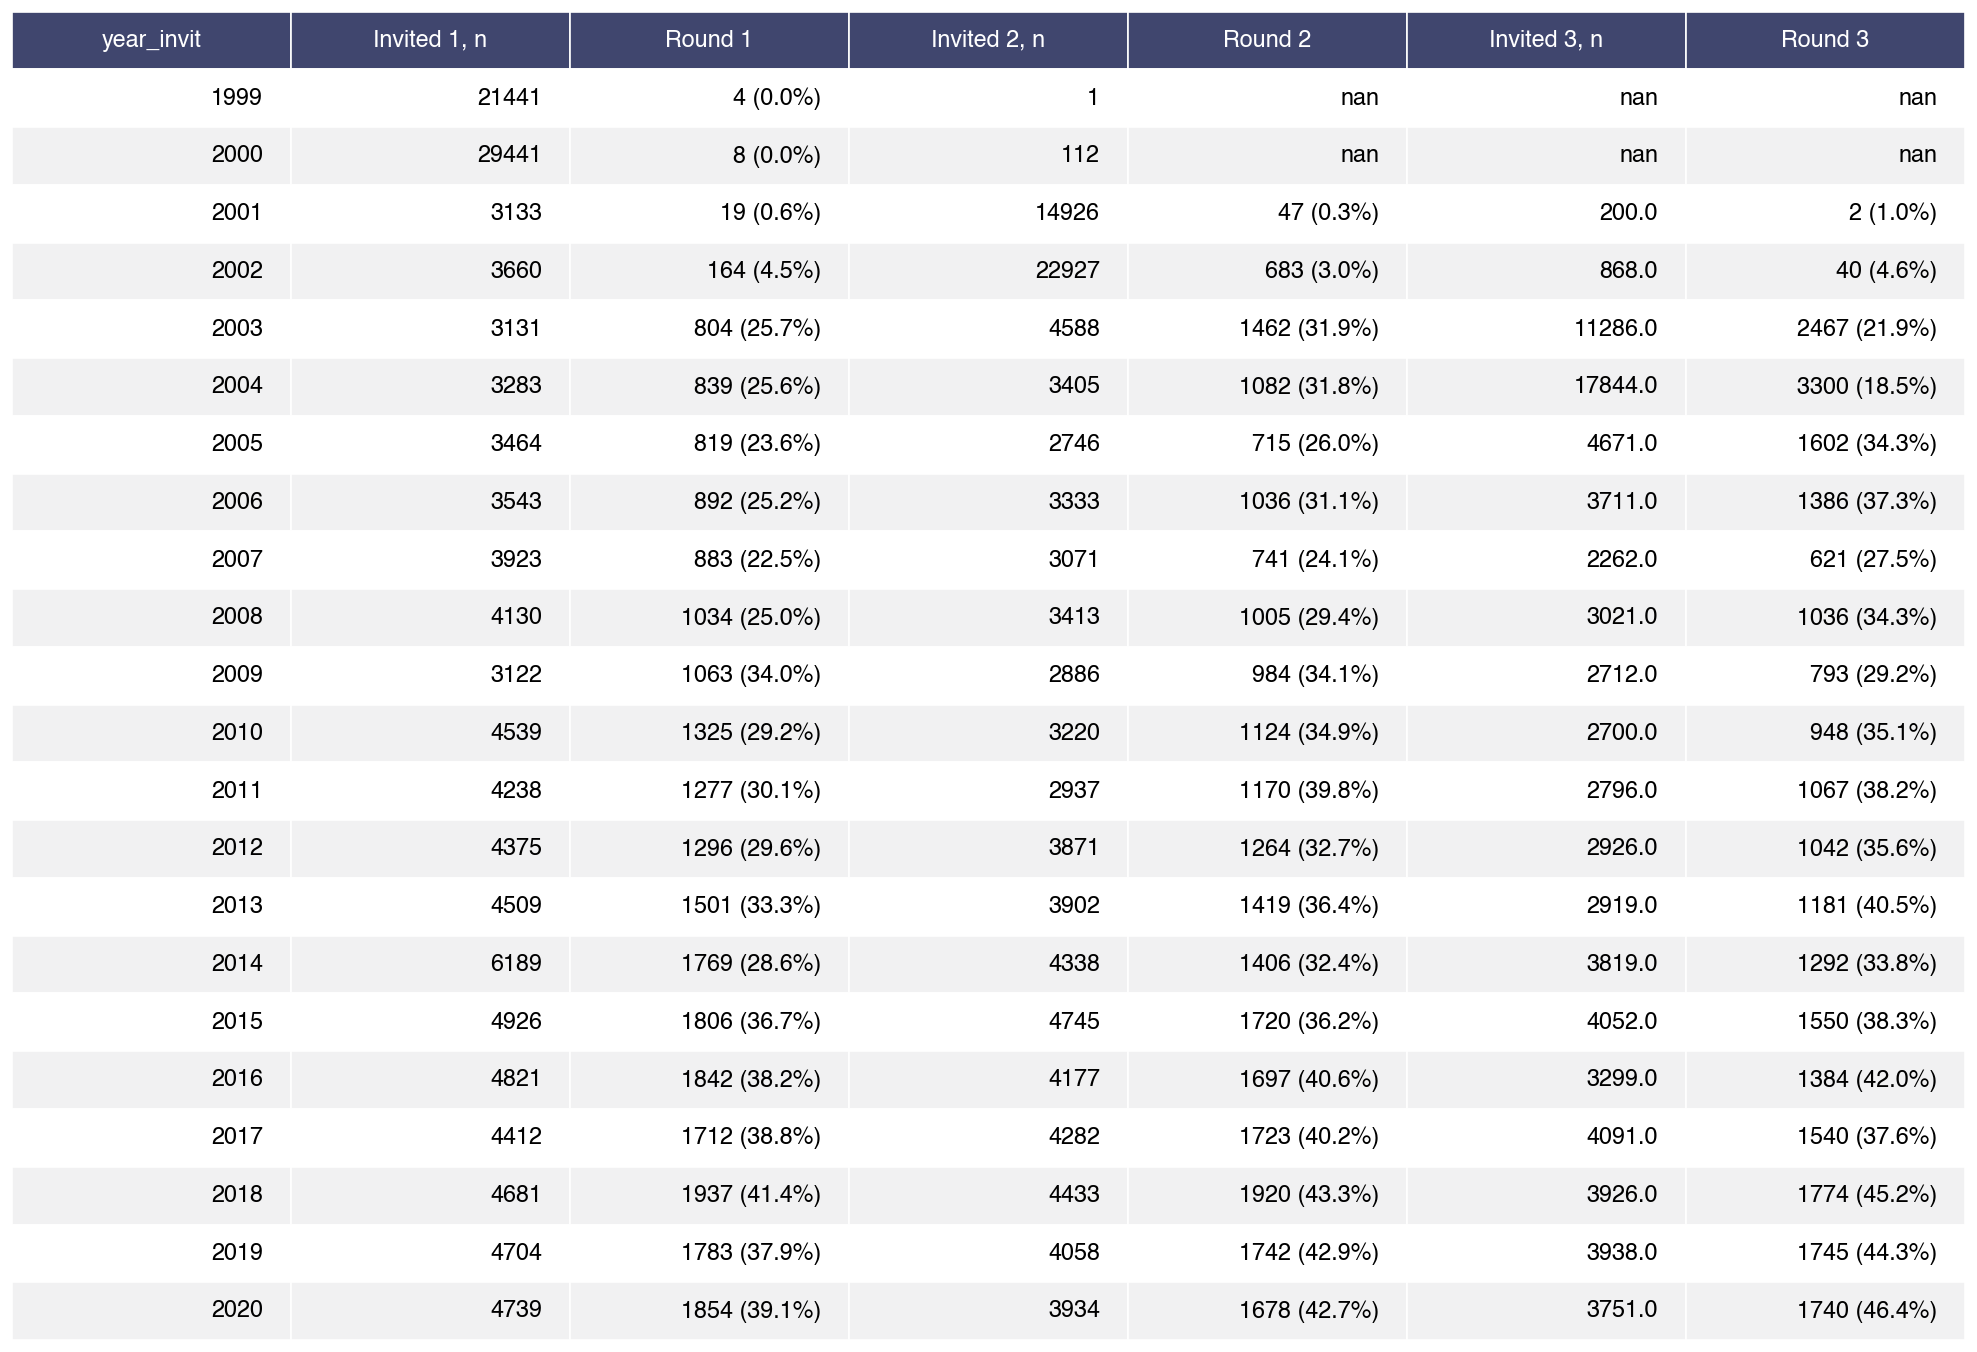

In [54]:
render_mpl_table(df_desc_screen.reset_index(), header_columns=0, col_width=3.0)

In [55]:
df_desc_screen = pd.DataFrame()
df_desc_screen['Invited 1, n'] = df_final[df_final.numeroinvitation_seq == 1].groupby('year_invit').numerodossier.count()
df_desc_screen['Round 1'] = df_final[(df_final.numeroinvitation_seq == 1)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count().astype(str)+' ('+(df_final[(df_final.numeroinvitation_seq == 1)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count()*100/df_desc_screen['Invited 1, n']).round(1).astype(str)+ '%)'
##
df_desc_screen['Invited 2, n'] = df_final[df_final.numeroinvitation_seq == 2].groupby('year_invit').numerodossier.count()
df_desc_screen['Round 2'] = df_final[(df_final.numeroinvitation_seq == 2)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count().astype(str)+' ('+(df_final[(df_final.numeroinvitation_seq == 2)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count()*100/df_desc_screen['Invited 2, n']).round(1).astype(str)+ '%)'
##
df_desc_screen['Invited 3, n'] = df_final[df_final.numeroinvitation_seq == 3].groupby('year_invit').numerodossier.count()
df_desc_screen['Round 3'] = df_final[(df_final.numeroinvitation_seq == 3)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count().astype(str)+' ('+(df_final[(df_final.numeroinvitation_seq == 3)&(df_final.mammo == 1)].groupby('year_invit').numerodossier.count()*100/df_desc_screen['Invited 3, n']).round(1).astype(str)+ '%)'

<AxesSubplot:>

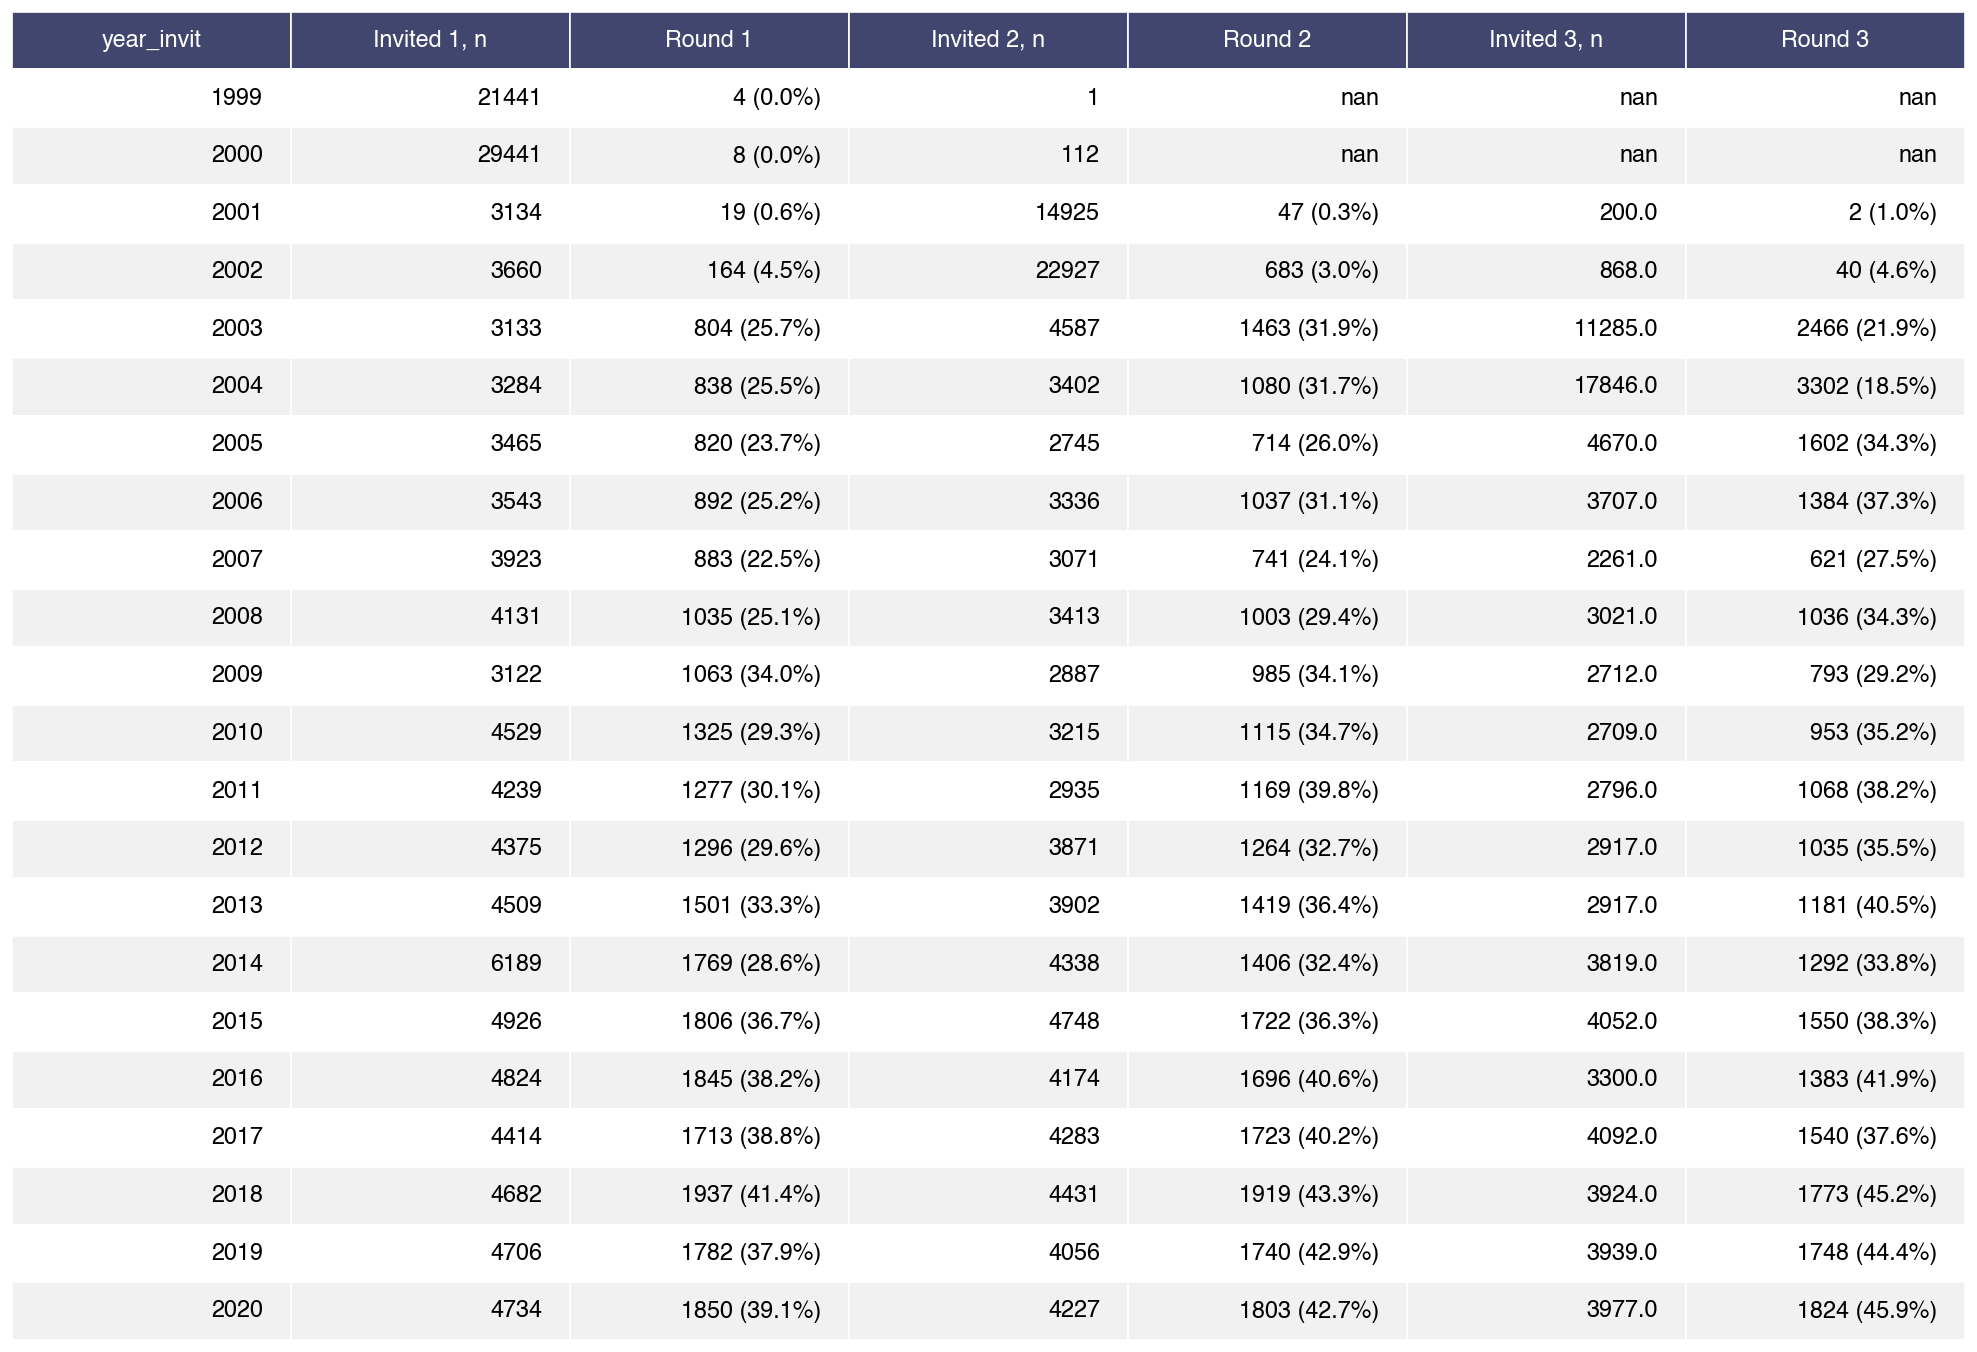

In [56]:
render_mpl_table(df_desc_screen.reset_index(), header_columns=0, col_width=3.0)

# Miscellaneous

In [57]:
import math
c = gdf.groupby(['nbid','mammo'])['mammo'].count()
test = (c / c.groupby(level=[0]).transform("sum")).unstack('nbid').fillna(0).T*100
test.columns = ['no','mammo_rate']
test['n'] = gdf.nbid.value_counts()
test['SEp'] = (test.mammo_rate*(100-test.mammo_rate))/test.n
test['SEp'] = test['SEp'].apply(lambda x: math.sqrt(x))

In [58]:
test.loc[test.SEp > 15,'mammo_rate'] = np.nan

In [59]:
microgis_data = pd.merge(microgis_data,test[['mammo_rate','SEp']],left_on = 'nbid',right_index = True, how = 'left')
microgis_data['mammo_rate_q5'] = pd.qcut(microgis_data['mammo_rate'],5, labels = False)

NameError: name 'microgis_data' is not defined

In [ ]:
microgis_data['rpdens'] = (microgis_data.ptot / microgis_data.geometry.area)*1000000

In [ ]:
gdf_centre = gdf_centre.to_crs(epsg = 2056)

In [ ]:
# ax = microgis_data.plot(alpha = 0.8,figsize = (10,10),color = microgis_data['mammo_rate_q5'].map(dict_cl), legend = True, linewidth = 0.2, edgecolor = 'k')
# gdf_centre.plot(ax = ax,markersize = 20, color = 'green',marker = 'x',linewidth = 0.5)
# ax.set_title('Taux de participation au dépistage du cancer du sein (quintiles) dans le canton de Genève.')
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite,crs = 'EPSG:2056')
# ax.set_axis_off()
# # add scale bar
# scalebar = ScaleBar(1, units="m", location="lower right")
# ax.add_artist(scalebar)
# ax.set_axis_off()

# x, y, arrow_length = 0.9, 0.15, 0.06
# ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)
# plt.savefig(result_folder/'Mammo_rate_cantongva.png',dpi = 800)

In [ ]:
microgis_gva = microgis_data[microgis_data.locality == 'Genève']

In [ ]:
# ax = microgis_gva.plot(alpha = 0.8,figsize = (10,10),color = microgis_gva['mammo_rate_q5'].map(dict_cl), legend = True, linewidth = 0.2, edgecolor = 'k')
# gdf_centre.plot(ax = ax,markersize = 20, color = 'black',marker = 'x',edgecolor='black')
# ax.set_title('Taux de participation au dépistage du cancer du sein (quintiles) dans le canton de Genève')
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite,crs = 'EPSG:2056')
# ax.set_axis_off()
# # add scale bar
# scalebar = ScaleBar(1, units="m", location="lower right")
# ax.add_artist(scalebar)
# ax.set_axis_off()
# x, y, arrow_length = 0.9, 0.15, 0.06
# ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)
# plt.savefig(result_folder/'Mammo_rate_gva.png',dpi = 800)

# Determinants of  participation, first participation, re-participation

## 1. Determinants of participation (any participation)

In [ ]:
df_final_wmicrogis = pd.merge(df_final,microgis_data[['nbid','deprivation_pca','rpdens','deprivation_pca_q5','pf',
 'p0004',
 'p0509',
 'p1014',
 'p1519',
 'p2024',
 'p2529',
 'p3034',
 'p3539',
 'p4044',
 'p4549',
 'p5054',
 'p5559',
 'p6064',
 'p6569',
 'p7074',
 'p7579',
 'p8084',
 'p8589',
 'p90m',                                                  
'rpnoce',
'rpncam',
'rpncas',
'rpnceu','rpneeu','rpneceu','rpnfe','rpnme','rpnnaf','rpnnam','rpnneu','rpnnweu','rpnsam','rpnsas','rpnseas','rpnseeu','rpnsweu','rpnsubaf','rpnweu',
'tertiary_education',
 'rpforeign',
 'wo_tertiary_education',
 'inv_ciqmd',
 'inv_dmdrent',
 'rad3primsec',
 'rp65+',
 'rphh3p-',
 'rphh3p+']], on='nbid',how = 'left')

In [ ]:
df_participation = df_final_wmicrogis[['numerodossier','uuid','groupeage','numeroinvitation','etatcivil','numeroinvitation_seq','numeroinvitation_seq_n','medecin','autremedecin','mammoanterieure','centre','atf','atf_code','numerodepistage','rpdens','rappel','t_invit_rappel','t_invit_mammo','month_rappel', 'year_invit', 'month_invit', 'day_invit',
       'city','rad3prim',
'rpnoce',
'rpncam',
'rpncas',
'rpnceu','rpneeu','rpneceu','rpnfe','rpnme','rpnnaf','rpnnam','rpnneu','rpnnweu','rpnsam','rpnsas','rpnseas','rpnseeu','rpnsweu','rpnsubaf','rpnweu',

 'rad3sec',
 'rad3tert',
 'rprprot',
 'rprcath',
 'rprochr',
 'rprjew',
 'rprmusl',
 'rproth',
 'rprnorel',
 'rpnch',
 'rphhpriv',
 'rpfnone',
 'rpfobl',
 'rpfgen',
 'rpfprof',
 'rpfmat',
 'rpfprsf',
 'rpfprss',
 'rpfbac',
 'rpfmas',
 'rpfphd',
 'rad',
 'radf',
 'radunef',
 'radslib',
 'tertiary_education',
 'rpforeign',
 'wo_tertiary_education',
 'inv_ciqmd',
 'inv_dmdrent',
 'rad3primsec',
 'rp65+',
 'rphh3p-',
 'rphh3p+',
 'dmdrent','ciqmd','income_ss','center_density','center_nearest','ptot','deprivation_pca','deprivation_pca_q5','diff_years','mammo_last_invite','participation_change','mammo','e','n']]
# df_participation = df[['numerodossier','groupeage','numeroinvitation','numerodepistage','etatcivil','rappel', 'year_invit', 'month_invit', 'day_invit','localité','center_density','center_nearest','mammo']]

In [ ]:
df_participation['age_cat'] = pd.factorize(df_participation['groupeage'], sort=True)[0] + 1 

In [ ]:
df_participation.loc[df_participation.city.str.contains('Meyrin'),'city'] = 'Meyrin'
df_participation.loc[df_participation.city.str.contains('Grand-Lancy'),'city'] = 'Grand-Lancy'
df_participation.loc[df_participation.city.str.contains('Petit-Lancy'),'city'] = 'Petit-Lancy'

In [ ]:
df_participation = pd.concat([df_participation,pd.get_dummies(df_participation.groupeage)],axis = 1)
# df_participation = pd.concat([df_participation,pd.get_dummies(df_participation.etatcivil),pd.get_dummies(df_participation.weekday_invit)],axis = 1).drop(['groupeage','etatcivil','weekday_invit'],axis = 1)

In [ ]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.api import abline_plot
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [ ]:
## Do we have any remaining NaNs?
df_participation.isna().sum().sort_values().tail(25)

In [ ]:
#Let's drop them, it only a few 100 out of 10^6
df_participation = df_participation.dropna(subset = ['ptot','deprivation_pca','ciqmd','rpdens'])

In [ ]:
geometry = [Point(xy) for xy in zip(df_participation['e'], df_participation['n'])]
# Coordinate reference system : WGS84
crs = 'epsg:2056'
df_participation = gpd.GeoDataFrame(df_participation, crs=crs, geometry=geometry)

In [ ]:
df_participation['groupeage'] = df_participation['groupeage'].astype('string') 

In [ ]:
df_participation.isna().sum().sort_values().tail(25)

In [ ]:
df_participation.shape

In [ ]:
df_participation.numerodossier.nunique()

In [ ]:
df_participation.to_csv('../Data/Processed data/20221004_GIRACS_all.csv',index = False)
df_participation.to_feather('../Data/Processed data/20221004_GIRACS_all.feather',index = False)

In [ ]:
df_participation.numerodossier.nunique()/136529 